In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
import numpy as np

# Διαβάζεις το CSV
df = pd.read_csv('C:\\Machine_Learning_Assignment\\output_features\\visible_hog_feature.csv')

# Χωρίζεις τα δεδομένα σε X και Y
X = df.iloc[:, :-1]  # Όλες οι στήλες εκτός από την τελευταία
y = df.iloc[:, -1]   # Η τελευταία στήλη (κλάση)


In [3]:
# Διαχωρισμός σε Training+Validation και Testing σετ με αναλογίες 80%-20%
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42  # Για αναπαραγωγιμότητα
)

#Αποθήκευση training+validation dataset και testing dataset για μελλοντικη χρήση
train_val_img =pd.concat([X_train_val,y_train_val], axis=1)
testing_img = pd.concat([X_test, y_test], axis=1)

# Αποθήκευση σε αρχείο CSV
train_val_img.to_csv('C:\\Machine_Learning_Assignment\\train_val_img.csv', index=False)
testing_img.to_csv('C:\\Machine_Learning_Assignment\\testing_img.csv', index=False)




KeyboardInterrupt



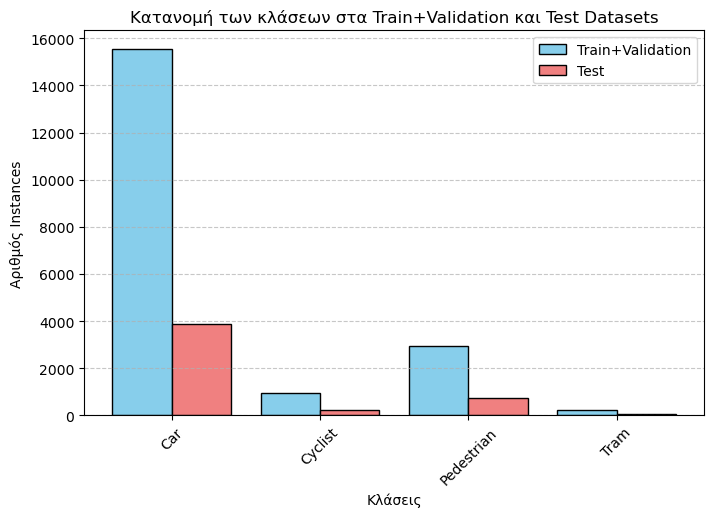

Κατανομή κλάσεων στο Training+Validation σετ:
class
Car           0.790300
Pedestrian    0.149060
Cyclist       0.048908
Tram          0.011732
Name: proportion, dtype: float64

Κατανομή κλάσεων στο Testing σετ:
class
Car           0.790169
Pedestrian    0.149096
Cyclist       0.048954
Tram          0.011781
Name: proportion, dtype: float64


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Υποθέτουμε ότι y_train_val και y_test υπάρχουν ήδη
# Αν όχι, θα πρέπει να φορτωθούν ξανά από τα αποθηκευμένα CSVs

# Υπολογισμός της κατανομής των κλάσεων
train_counts = y_train_val.value_counts()
test_counts = y_test.value_counts()

# Ταξινόμηση των labels για συνέπεια στις μπάρες
class_labels = sorted(set(train_counts.index).union(set(test_counts.index)))

# Δημιουργία λιστών με τα counts
train_values = [train_counts.get(cls, 0) for cls in class_labels]
test_values = [test_counts.get(cls, 0) for cls in class_labels]

# Δημιουργία διπλού bar plot
x = np.arange(len(class_labels))  # Δείκτες για τις μπάρες
width = 0.4  # Πλάτος μπάρας

plt.figure(figsize=(8,5))
plt.bar(x - width/2, train_values, width, label="Train+Validation", color="skyblue", edgecolor="black")
plt.bar(x + width/2, test_values, width, label="Test", color="lightcoral", edgecolor="black")

# Προσαρμογή των labels
plt.xticks(x, class_labels, rotation=45)
plt.xlabel("Κλάσεις")
plt.ylabel("Αριθμός Instances")
plt.title("Κατανομή των κλάσεων στα Train+Validation και Test Datasets")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Αποθήκευση του διαγράμματος
plt.savefig("train_test_class_distribution.png", dpi=300)
plt.show()
# Επιβεβαίωση των αναλογιών
print("Κατανομή κλάσεων στο Training+Validation σετ:")
print(y_train_val.value_counts(normalize=True))
print("\nΚατανομή κλάσεων στο Testing σετ:")
print(y_test.value_counts(normalize=True))


In [28]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
# Λίστα τιμών για την παράμετρο C
C_values = [0.1, 0.3, 0.5, 1.0, 2.0, 5.0]  

k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42) #Ορισμός του KFold validation

f1=[]
var=[]

# Ορισμός των στρατηγικών υπερδειγματοληψίας και υποδειγματοληψίας
over_sampling_strategy = {'Tram': 3500, 'Cyclist': 3500}
under_sampling_strategy = {'Car': 3500}

# Εκπαίδευση SVM για κάθε τιμή του C
for C in C_values:
    # Φτιάχνουμε ένα Pipeline που πρώτα κάνει scaling και μετά καλεί τον SVC
    model = ImbPipeline([
        ("scaler", StandardScaler()),
        ("smote", SMOTE(sampling_strategy=over_sampling_strategy, random_state=42)),
        ("under", RandomUnderSampler(sampling_strategy=under_sampling_strategy, random_state=42)),
        ("pca", PCA(n_components=300)),
        ("svc", svm.SVC(C=C))
    ])
    scores = cross_val_score(model, X_train_val, y_train_val, cv=cv, scoring='f1_macro', n_jobs=-1) #Εκπαίδευση του μοντέλου για τα 5 διαφορετικά folds των train και test data
    mean_score = np.mean(scores) #Υπολογισμός των μέσων όρων του Macro f1
    var_score = np.var(scores) #Υπολογισμός της διακύμανσης
    f1.append(mean_score)
    var.append(var_score)

In [30]:
# Εκτύπωση αποτελεσμάτων
print("C\tMean Macro F1\tVariance")
for i, C in enumerate(C_values):
    print(f"{C}\t{f1[i]:.3f}\t\t{var[i]:.6f}")

C	Mean Macro F1	Variance
0.1	0.922		0.000037
0.3	0.945		0.000028
0.5	0.951		0.000033
1.0	0.959		0.000016
2.0	0.960		0.000007
5.0	0.961		0.000006


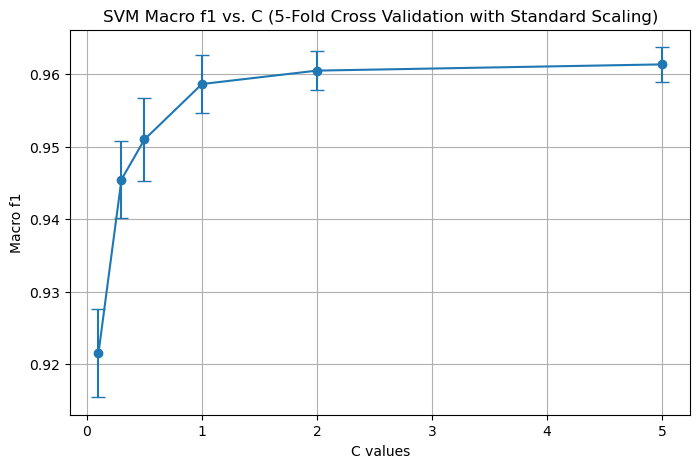

In [32]:
# plot των αποτελεσμάτων για κάθε C
plt.figure(figsize=(8, 5))
plt.errorbar(C_values, f1, yerr=np.sqrt(var), fmt='-o', capsize=5)
plt.title("SVM Macro f1 vs. C (5-Fold Cross Validation)
plt.xlabel("C values")
plt.ylabel("Macro f1")
plt.grid(True)
plt.show()

C = 0.1: Mean Macro F1 = 0.6549, Variance = 0.0003
C = 0.3: Mean Macro F1 = 0.9095, Variance = 0.0001
C = 0.5: Mean Macro F1 = 0.9307, Variance = 0.0000
C = 1.0: Mean Macro F1 = 0.9505, Variance = 0.0000
C = 2.0: Mean Macro F1 = 0.9600, Variance = 0.0000
C = 5.0: Mean Macro F1 = 0.9637, Variance = 0.0000


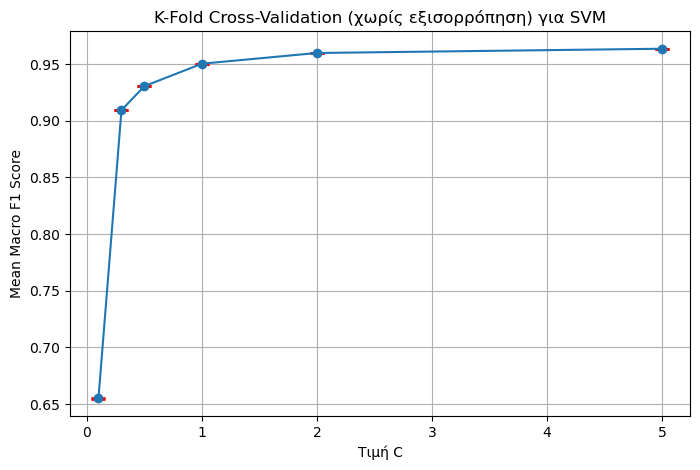

In [14]:
import numpy as np
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score

# Λίστα τιμών για την παράμετρο C του SVM
C_values = [0.1, 0.3, 0.5, 1.0, 2.0, 5.0]

# Ορισμός του KFold Cross-Validation (π.χ., 5-fold)
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

# Λίστες για την αποθήκευση των μέσων τιμών και της διακύμανσης του Macro F1 score
f1_scores_mean = []
f1_scores_var = []

# Επαναλαμβάνουμε τη διαδικασία για κάθε τιμή του C
for C in C_values:
    # Δημιουργία Pipeline χωρίς βήματα εξισορρόπησης
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=300)),
        ("svc", svm.SVC(C=C))
    ])
    
    # Εκτέλεση Cross-Validation με scoring το f1_macro
    scores = cross_val_score(model, X_train_val, y_train_val, cv=cv, scoring='f1_macro', n_jobs=-1)
    
    # Υπολογισμός μέσου όρου και διακύμανσης των scores
    mean_score = np.mean(scores)
    var_score = np.var(scores)
    
    # Αποθήκευση των αποτελεσμάτων στις αντίστοιχες λίστες
    f1_scores_mean.append(mean_score)
    f1_scores_var.append(var_score)
    
    print(f"C = {C}: Mean Macro F1 = {mean_score:.4f}, Variance = {var_score:.4f}")



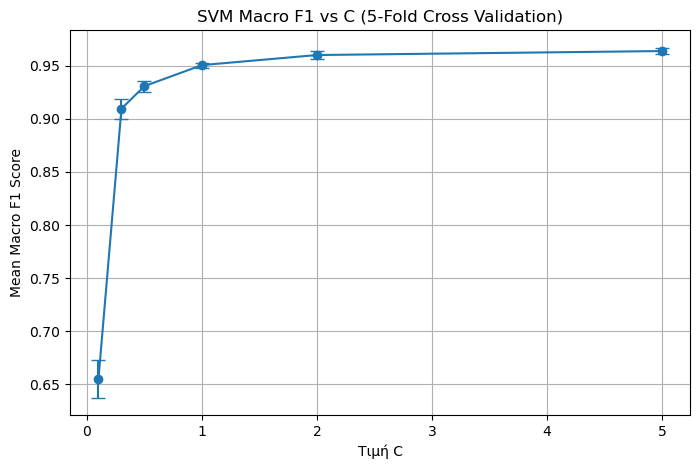

Αποτελέσματα Hyperparameter Tuning για SVM (χωρίς εξισορρόπηση):
------------------------------------------------------------
C = 0.1 : Mean Macro F1 = 0.654891, Std = 0.000310
C = 0.3 : Mean Macro F1 = 0.909462, Std = 0.000090
C = 0.5 : Mean Macro F1 = 0.930696, Std = 0.000027
C = 1.0 : Mean Macro F1 = 0.950487, Std = 0.000006
C = 2.0 : Mean Macro F1 = 0.959960, Std = 0.000014
C = 5.0 : Mean Macro F1 = 0.963708, Std = 0.000010


In [24]:
plt.figure(figsize=(8,5))
plt.errorbar(C_values, f1_scores_mean, yerr=np.sqrt(f1_scores_var), fmt='o-', capsize=5)
plt.xlabel('Τιμή C')
plt.ylabel('Mean Macro F1 Score')
plt.title('SVM Macro F1 vs C (5-Fold Cross Validation)')
plt.grid(True)
plt.show()

print("Αποτελέσματα Hyperparameter Tuning για SVM (χωρίς εξισορρόπηση):")
print("-" * 60)
for C, mean_val, std_val in zip(C_values, f1_scores_mean, f1_scores_var):
    print(f"C = {C:<4}: Mean Macro F1 = {mean_val:.6f}, Std = {std_val:.6f}")

In [48]:
# Εκπαίδευση του τελικού μοντέλου με το καλύτερο C σε όλο το Training+Validation σετ
final_model = ImbPipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(sampling_strategy=over_sampling_strategy, random_state=42)),
    ("under", RandomUnderSampler(sampling_strategy=under_sampling_strategy, random_state=42)),
    ("pca", PCA(n_components=300)),
    ("svc", svm.SVC(C=2.0, probability=True))
])

final_model.fit(X_train_val, y_train_val)

# Αξιολόγηση στο Testing σετ
y_pred = final_model.predict(X_test)
print("\nClassification Report στο Testing σετ:")
print(classification_report(y_test, y_pred))


Classification Report στο Testing σετ:
              precision    recall  f1-score   support

         Car       1.00      0.99      1.00      3890
     Cyclist       0.94      0.91      0.92       241
  Pedestrian       0.95      0.99      0.97       734
        Tram       1.00      1.00      1.00        58

    accuracy                           0.99      4923
   macro avg       0.97      0.97      0.97      4923
weighted avg       0.99      0.99      0.99      4923



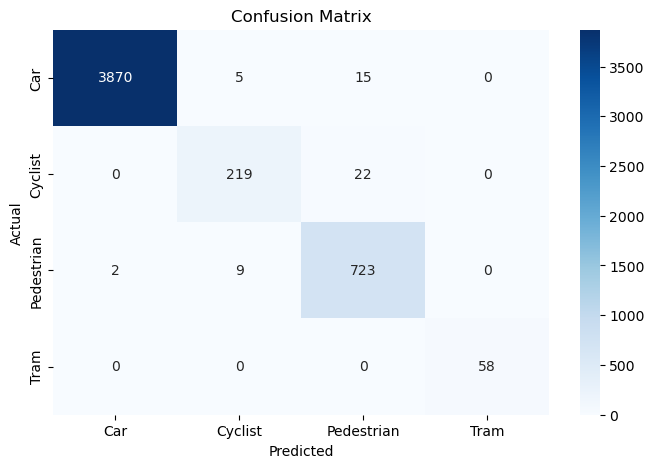

Macro F1-score στο Testing σετ: 0.9723


In [50]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Δημιουργία Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
classes = np.unique(y)  # Λήψη των ονομάτων των κλάσεων

# Οπτικοποίηση του Confusion Matrix
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Υπολογισμός Macro F1-score
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"Macro F1-score στο Testing σετ: {macro_f1:.4f}")

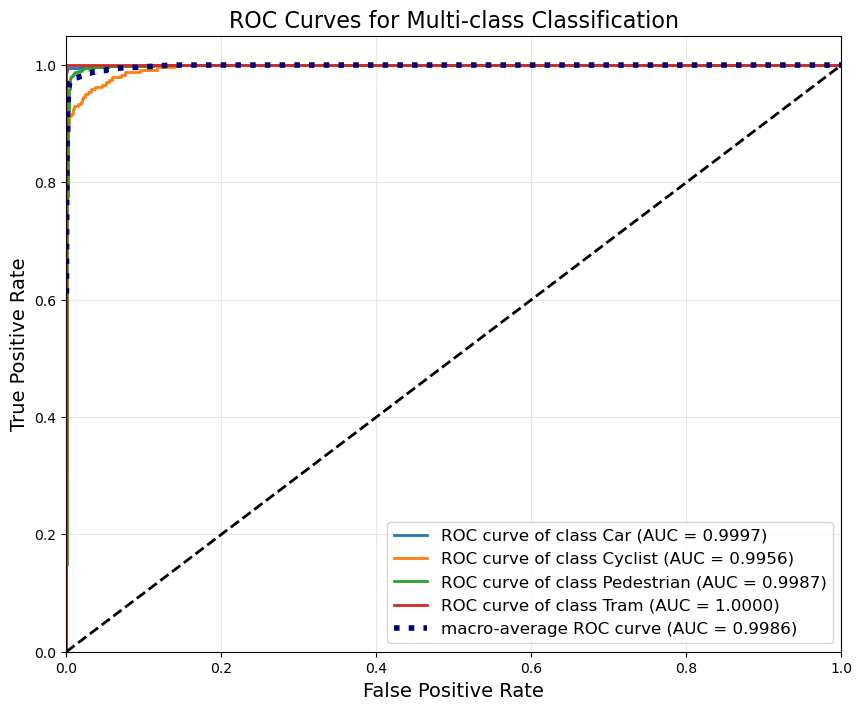

In [60]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Δημιουργία ROC Curves

# Binarize the output labels for ROC
y_test_binarized = label_binarize(y_test, classes=classes)
n_classes = y_test_binarized.shape[1]

# Λήψη των scores από το μοντέλο
y_score = final_model.decision_function(X_test)

# Υπολογισμός ROC curve και AUC για κάθε κλάση
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Υπολογισμός Macro ROC Curve
from sklearn.preprocessing import label_binarize

# Calculate macro-average ROC curve and ROC area
# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

# Plot ROC curve for each class
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (AUC = {1:0.4f})'
             ''.format(classes[i], roc_auc[i]))

# Plot macro-average ROC curve
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (AUC = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves for Multi-class Classification', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()